# Models: LDA, Linear Regression, Logistic Regression, QDA

In this notebook 4 common clasification models are coded from scratched and tested on 2D data

In [274]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import cm
import pylab as pl



filenames = [('classification_data_HWK1/classificationA.train','classification_data_HWK1/classificationA.test'),
            ('classification_data_HWK1/classificationB.train','classification_data_HWK1/classificationB.test'),
            ('classification_data_HWK1/classificationC.train','classification_data_HWK1/classificationC.test')]

figures = ["Atrain", "Btrain", "Ctrain"]


In [275]:
# COMMON FUNCTION
def extractdata(classification, testfile):
    """ extrac the trainning data end test data given the path
    to these files"""
    train  = pd.read_table(classification, header=None, engine='python')
    test = pd.read_table(testfile, header=None, engine='python')
    X_train, X_test = train.as_matrix()[:,0:2], test.as_matrix()[:,0:2]
    y_train, y_test = train.as_matrix()[:,2], test.as_matrix()[:,2]
    return X_train, y_train, X_test, y_test

def quadratic_form(x, A):
    """
    Computes the image of x by the quadratic form represented by a symetric matrix A
    """
    if(len(x.shape) == 1):
        x = x[np.newaxis, ...]
    return np.einsum('ij,ij->i', x, np.dot(x, A))

def quadratic_function(x, A, w, b):
    """
    Computes the image of x by the quadratic function represented by the symetric matrix A, 
    the vector w, and the bias b
    """
    return(quadratic_form(x, A) + np.dot(x, w) + b)

def linear_function(x, w, b):
    """
    Computes the image of x by the linear function represented by coefficients w and b
    """
    return x.dot(w.T) + b

def sigmoid(x):
    """
    Sigmoid function
    """
    return 1/(1 + np.exp(-x))

def decision(y):
    return (np.array(y) > 0.5).astype(int)

In [276]:
## Plot functions

def plot_data(data, labels=None, markers = ['o', 's']):
    """
    Plot 2d points representing the data
    """
    if labels is None:
        plt.scatter(data[:, 0], data[:, 1], c='b', s = 80, marker = markers[0])
    
    else:
        classes = np.sort(np.unique(labels))
        n_classes = classes.shape[0]
        color_blind_list = sns.color_palette("colorblind", n_classes)
        sns.set_palette(color_blind_list)
        
        for i, l in enumerate(classes):
            plt.scatter(data[labels == l, 0], 
                        data[labels == l, 1],
                        c=color_blind_list[i], 
                        s=80, 
                        marker=markers[i])

def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, n_points = 400):
    """
    Computes a plotting grid given the data.
    xmin, xmax, ymin, ymax is used by default if no data is given as input
    """
    if data is not None:
        xmin, ymin = np.min(data, axis = 0)
        xmax, ymax = np.max(data, axis = 0)
        
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    
    x, y = np.meshgrid(np.linspace(xmin, xmax, n_points), np.linspace(ymin, ymax, n_points))
    grid = np.c_[x.ravel(), y.ravel()] # grid has n_points ^2 row and 2 columns
    return x, y, grid

def plot_separator(data, w, b, C=None):
    """
    Plots the decision separator  
    """
    x, y, grid = make_grid(data)
    if(C is None):
        C = np.zeros((w.shape[0], w.shape[0]))
    f = lambda x: quadratic_function(x, C, w, b)
    
    color_blind_list = sns.color_palette("colorblind", 2)
    sns.set_palette(color_blind_list)
        
    plt.contour(x, y, f(grid).reshape(x.shape),  levels = 0, alpha = 1)
    plt.show()


 

Results file A
w =  [-6.62245258 -9.3462503 ] 
b =  [-0.13649629]
Training error: 0.013333 
Test error: 0.020000


/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


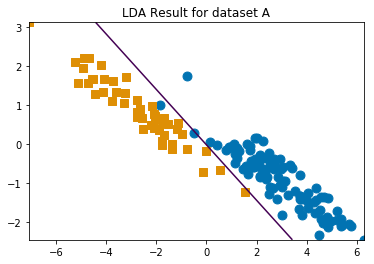

Results file B
w =  [-1.92108197  0.95442836] 
b =  [0.00092929]
Training error: 0.030000 
Test error: 0.041500


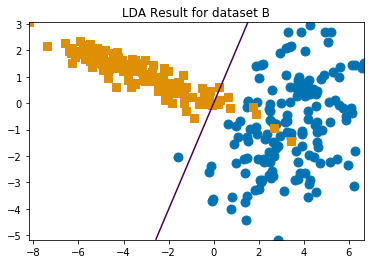

Results file C
w =  [-2.05129911 -0.27311529] 
b =  [0.11242913]
Training error: 0.055000 
Test error: 0.042333


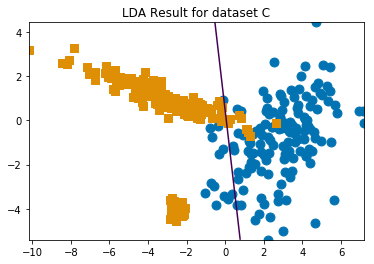

In [277]:
#LDA FUNCTIONS      

class LDA(object):
    """
    class for binary Linear Discriminant Analysis 
    """
    
    def __init__(self):
        self.m0 = None
        self.m1 = None
        self.sigma = None
        self.pi = None
        
    def fit(self, X_tr, y_tr):
        """ 
        Takes the trainning data, estimates sigma, m0, m1 and returns the coefficients
        w, b and pi 
        """
        # N samples
        n = np.shape(X_tr)[0]

        # MLE Means
        self.m0 = np.mean(X_tr[y_tr == 0], axis=0)
        self.m1 = np.mean(X_tr[y_tr == 1], axis=0)
        
        # MLE class 1 probability 
        self.pi = float(np.shape(X_tr[y_tr == 1])[0]) / n
        
        # MLE Covariance
        sigma1 = np.dot((X_tr[y_tr == 1] - self.m1).T, X_tr[y_tr == 1] - self.m1)
        sigma0 = np.dot((X_tr[y_tr == 0] - self.m0).T, X_tr[y_tr == 0] - self.m0)
        
        self.sigma = (sigma1 + sigma0) / n
        
        return self.m0, self.m1, self.sigma, self.pi
    
    def get_separator(self):
        """
        Returns the separator coefficients w, b 
        """
        sigma_inv = np.linalg.inv(self.sigma)
        w = np.dot(sigma_inv, self.m1 - self.m0)
        b = 0.5 * (quadratic_form(self.m0, sigma_inv) - quadratic_form(self.m1, sigma_inv)) - math.log((1 - self.pi) / self.pi)
        return w, b

    def get_params(self):
        """
        Returns the current parameters of the model
        """
        return self.m0, self.m1, self.sigma, self.pi
    
    def predict_proba(self, X_t):
        """
        Predicts the probability of the class "1" for each line of X_test
        """
        w, b = self.get_separator()
        arg = np.dot(X_t, w) + b
        y_prob = sigmoid(np.dot(X_t, w) + b)
        return y_prob
    
    def predict(self, X_t, probability_treshold = 0.5):
        """
        Predicts the classes of the elements in X_test given a probability treshold
        """
        y_prob = self.predict_proba(X_t)
        return (y_prob > probability_treshold).astype(int)
    
    

   
for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    lda = LDA()
    lda.fit(X_train, y_train)
    w, b = lda.get_separator()
    print("Results file %s" %("ABC"[s]))

    print("w = ", w, "\n"+"b = ", b)
    y_test_pred = lda.predict(X_test)
    y_train_pred = lda.predict(X_train)

    train_error = np.mean(y_train != y_train_pred)
    test_error = np.mean(y_test !=  y_test_pred)
    print("Training error: %f \nTest error: %f" %(train_error, test_error))
    name = figures[s]+"lda.png"
    plt.title("LDA Result for dataset %s" %("ABC"[s]))
    plot_data(X_train, y_train)
    plot_separator(X_train, w, b)



## Linear regression

w =  [-0.2640075  -0.37259311] 
 b =  0.4922920375647636
Training error: 0.013333 
Test error: 0.020667


/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


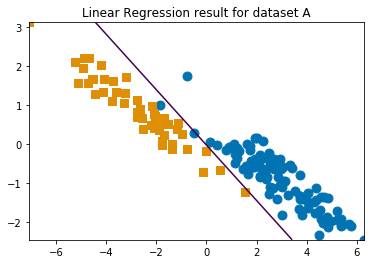

w =  [-0.10424575  0.05179118] 
 b =  0.5000504269997569
Training error: 0.030000 
Test error: 0.041500


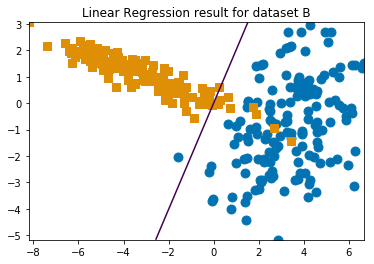

w =  [-0.12769333 -0.01700142] 
 b =  0.508399815826349
Training error: 0.055000 
Test error: 0.042333


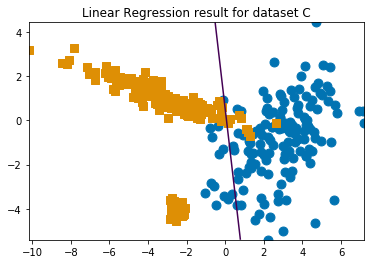

In [278]:
#linear regression
class LinearRegression(object):
    """
    Class for linear regression
    """
    
    def __init__(self):
        self.w = None
        self.b = None
    
    def fit(self, X_tr, y_tr):
        """ 
        Trains the linear model using MLSE
        """
        n,p = np.shape(X_tr)
        ones = np.ones((n, 1))
        
        X_aug = np.c_[X_tr, ones]

        M = np.dot(X_aug.T, X_aug)

        b = np.dot(X_aug.T, y_tr)
        
        w_aug = np.linalg.solve(M, b)

        self.w = w_aug[0:p]
        self.b = w_aug[p]
        return self.w, self.b
    
    def get_params(self):
        return self.w, self.b
    
    def predict_regressor(self, X_t):
        """
        Predicts the ouput of the linear function given the input X_t
        """
        return X_t.dot((self.w).T) + self.b
    def predict(self, X_t, treshold = 0.5):
        """
        Predicts the binary class of X based on treshold
        """
        return (X_t.dot((self.w).T) + self.b > treshold).astype(int)
    
for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    linreg = LinearRegression()
    w, b = linreg.fit(X_train, y_train)
    
    print("w = ", w, "\n", "b = ", b)
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test)
        

    train_error = np.mean(y_train != y_train_pred)
    test_error = np.mean(y_test !=  y_test_pred)
    print("Training error: %f \nTest error: %f" %(train_error, test_error))

    plt.title("Linear Regression result for dataset %s" %("ABC"[s]))
    plot_data(X_train, y_train)
    
    plot_separator(X_train, w, b - 0.5)
    


    

## Logistic regression

w =  [-182.06790875 -315.05580399  -30.64398373]
Training error: 0.000000 
Test error: 0.034667


/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


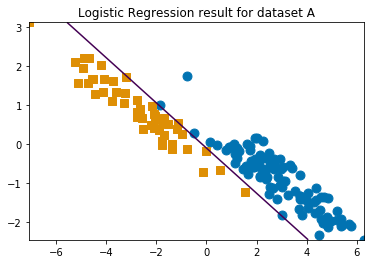

w =  [-1.70518566  1.02378525  1.3495913 ]
Training error: 0.020000 
Test error: 0.043000


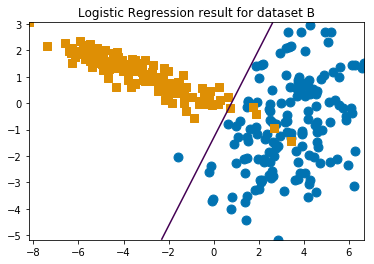

w =  [-2.20323226  0.70926552  0.95918875]
Training error: 0.040000 
Test error: 0.022667


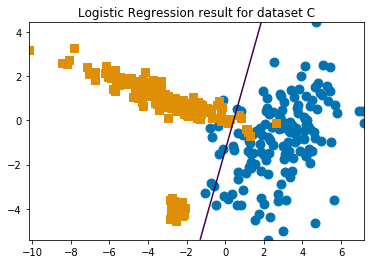

In [279]:
#Logistic regression

class LogisticRegression(object):
    """
    Class for logistic regression
    """
    
    def __init__(self):
        self.w = None
        
    def gradient(self, X_tr, y_tr, w):
        """
        Computes the gradient and the hessian of the log likelihood of (X_t, y_t) with respect to parameter w
        """
        n = np.shape(X_tr)[0]
        
        Xe = np.c_[X_tr, np.ones(n)] # Append X_tr with ones to include bias term 
        
        eta = sigmoid(np.dot(Xe, w.T))
        
        grad = np.dot(Xe.T, np.reshape((y_tr - eta), (n, 1)))
        
        sigma = np.diag(eta * (1 - eta))
        
        hessian = np.dot(- Xe.T, np.dot(sigma, Xe))

        return grad, hessian
        
    
    def fit(self, X_tr, y_tr, tol = 0.001):
        """
        Trains the logistic regression model using the IRLS (Newton- Raphson) algorithm
        """
        w = np.zeros((X_tr.shape[1] + 1)) # bias included in the coefficient vector
        
        g, H = gradcompute(X_tr,y_tr, w)
        
        while (np.linalg.norm(g) > tol):
            # Newton-Ralphson step
            w = w - np.ravel(np.dot(np.linalg.inv(H), g))
            
            # Update gradient and Hessian
            g, H = self.gradient(X_tr, y_tr, w)
            
        self.w = w
        return w
    
    def predict_proba(self, X_t):
        """
        Predicts the output class probabilities of the input X_t
        """
        return sigmoid(np.dot(X_t, (self.w[:2]).T) + self.w[2])
    
    def predict(self, X_t, treshold = 0.5):
        """
        Predicts the output class of the input X_t
        """
        y_prob = self.predict_proba(X_t)
        return (y_prob > treshold).astype(int)
    
for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    
    logreg = LogisticRegression()
    w = logreg.fit(X_train, y_train)
    
    print("w = ", w)
    y_train_pred = logreg.predict(X_train)
    y_test_pred = logreg.predict(X_test)
        
    train_error = np.mean(y_train != y_train_pred)
    test_error = np.mean(y_test !=  y_test_pred)
    print("Training error: %f \nTest error: %f" %(train_error, test_error))

    plt.title("Logistic Regression result for dataset %s" %("ABC"[s]))
    plot_data(X_train, y_train)
    
    plot_separator(X_train, w[:2], w[2])
    



In [281]:
## Quadratic discriminant analysis

C:
[[-0.7587202  -1.51361485]
 [-1.51361485 -2.86166338]]
W: [ -7.36527314 -10.87335416]
b: -0.6262714530181466
Training error: 0.006667 
Test error: 0.020000


/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/Users/raphaelromero/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


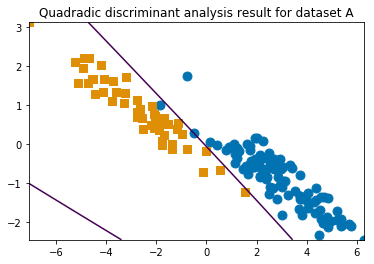

C:
[[-0.47982628 -1.92382528]
 [-1.92382528 -5.52933507]]
W: [-2.28065009  1.45700199]
b: 2.673354675441125
Training error: 0.016667 
Test error: 0.020500


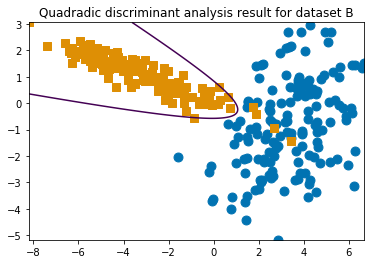

C:
[[ 0.00244301 -0.14592984]
 [-0.14592984  0.11805533]]
W: [-2.66524064  0.34888942]
b: -1.0939300554338616
Training error: 0.047500 
Test error: 0.038333


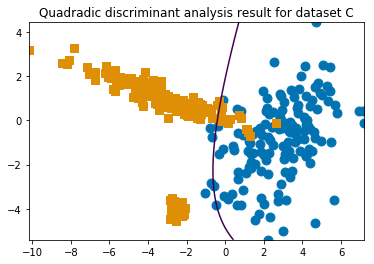

In [282]:
class QDA(object):
    """
    Class for quadratic discriminant analysis
    """
    def __init__(self):
        self.pi = None
        self.m0 = None
        self.m1 = None
        self.sigma0 = None
        self.sigma1 = None
        
    def fit(self, X_tr, y_tr):
        """
        Trains the quadratic model using MLE
        """
        
        # N samples
        n = np.shape(X_tr)[0]
        n1 = X_tr[y_tr == 1].shape[0]
        n0 = X_tr[y_tr == 0].shape[0]
        # MLE Means
        m0 = np.mean(X_tr[y_tr == 0], axis=0)
        m1 = np.mean(X_tr[y_tr == 1], axis=0)
        
        # MLE class 1 probability 
        self.pi = float(np.shape(X_tr[y_tr == 1])[0]) / n
        
        # MLE Covariance
        sigma1 = np.dot((X_tr[y_tr == 1] - m1).T, X_tr[y_tr == 1] - m1) / n1
        sigma0 = np.dot((X_tr[y_tr == 0] - m0).T, X_tr[y_tr == 0] - m0) / n0
        
        # Save parameters
        self.m0 = m0
        self.m1 = m1
        self.sigma0 = sigma0
        self.sigma1 = sigma1
        
        return m0, m1, sigma0, sigma1
    
    def get_params(self):
        """
        Returns the model parameters
        """
        return self.m0, self.m1, self.sigma0, self.sigma1, self.pi
    
    def get_coefficients(self):
        """
        Computes the quadratic coeficients C, w, b based on the model parameters
        C, w, b are used to compute the estimated conditional probability of y given x in the QDA case
        """
        det0 = np.linalg.det(self.sigma0)
        det1 = np.linalg.det(self.sigma1)
        A0 = np.linalg.inv(self.sigma0)
        A1 = np.linalg.inv(self.sigma1)
        m0 = self.m0
        m1 = self.m1
        
        b = (np.dot(m0,np.dot(A0, m0)) - np.dot(m1, np.dot(A1, m1))) / 2 - math.log((1 - pi) / pi) - math.log(det1 / det0)/2
        w = np.dot(A1, m1) - np.dot(A0, m0)
        C = (A0 - A1)/2
        return C, w, b
    
    def predict_proba(self, X_t):
        """
        Predicts the output class probabilities given the input X_t
        """
        C, w, b = self.get_coefficients()
        return(sigmoid(quadratic_function(X_t, C, w, b)))
    
    def predict(self, X_t, treshold = 0.5):
        """
        Predicts the output class given the input X_t
        """
        y_prob = self.predict_proba(X_t)
        return (y_prob > treshold).astype(int)
    
    
    

for s, names in enumerate(filenames) :
    X_train, y_train, X_test, y_test = extractdata(names[0], names[1])
    qda = QDA()
    
    qda.fit(X_train, y_train)
    
    C, w, b = qda.get_coefficients()
    print ("C:")
    print(C)
    print("W:", w)
    print("b:", b)
    
    
    y_train_pred = qda.predict(X_train)
    y_test_pred = qda.predict(X_test)
        
    train_error = np.mean(y_train != y_train_pred)
    test_error = np.mean(y_test !=  y_test_pred)
    
    print("Training error: %f \nTest error: %f" %(train_error, test_error))

    plt.title("Quadradic discriminant analysis result for dataset %s" %("ABC"[s]))
    plot_data(X_train, y_train)
    
    plot_separator(X_train, w, b, C)
    